# **\[SOLAR_A\]** gclstm

JiyunLim  
2023-08-31

## GCLSTM

In [1]:
%run test_model/glstm

In [2]:
# read dataframe 
df = pd.read_csv('data_eng_230710.csv')

# make y, y_upper, y_period, time, regions 
y = df.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
yU = df.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
yP = np.divide(y, yU+1e-10)

t = df.loc[:,'date']
regions = list(df.loc[:, 'Bukchoncheon':'Gyeongju-si'].columns)

In [3]:
# global parameters
TRAIN_RATIO = 0.8
T, N = len(t), len(regions)
LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
LEN_TR = T - LEN_TEST

In [4]:
# create lrnr object
lrnr = RGCN_Learner()
# load data
lrnr.lags = 24
lrnr.train_ratio = 0.8
lrnr.load(y)
# construct network
lrnr.nof_filters = 16
lrnr.model = GC_LSTM(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(), lr=50/1000)
# learn
lrnr.get_batches(128)
for e in range(5):
    lrnr.learn()

epoch=1  loss=0.4248037058860063630418396   
epoch=2  loss=0.1400049622170627532440186   
epoch=3  loss=0.1074125436134636479239273   
epoch=4  loss=0.1010394608601927855060196   
epoch=5  loss=0.0948439138010144246707153   

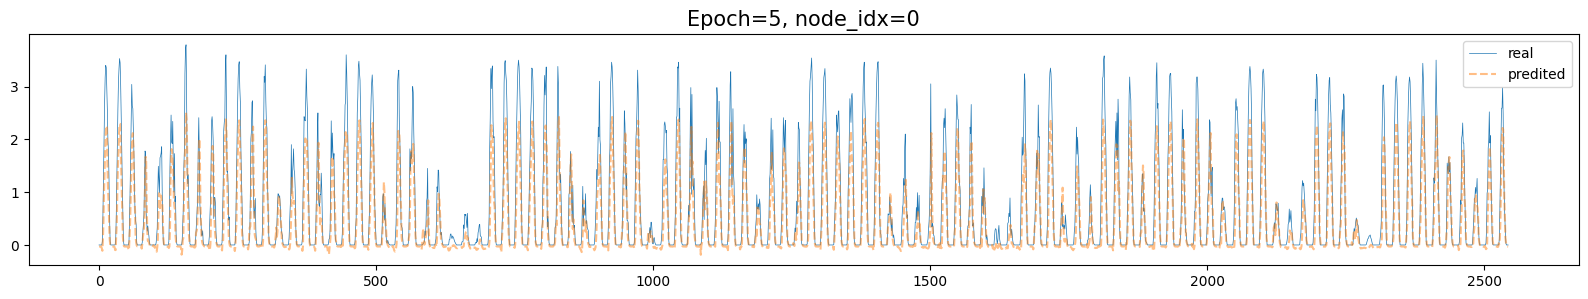

In [5]:
lrnr.figs[-1]

In [7]:
yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
yhat[yhat<0] = 0

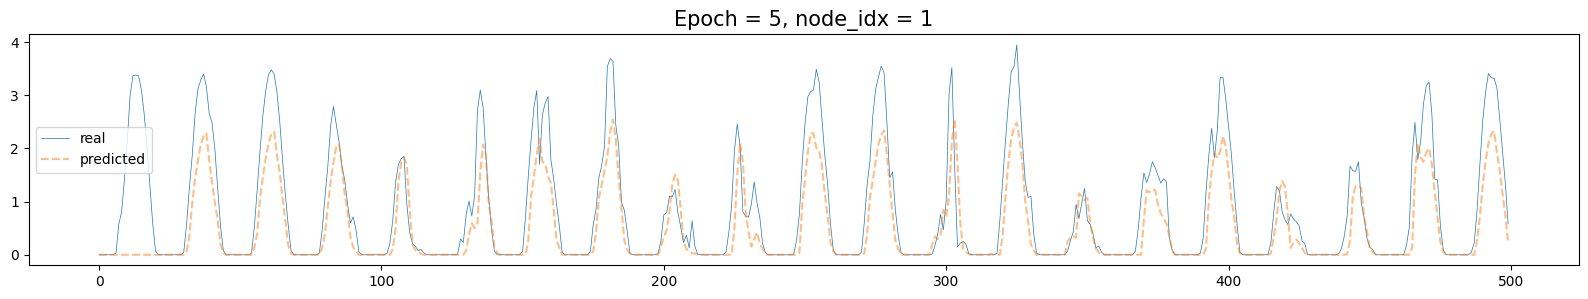

In [8]:
rslt_plot(lrnr, y, yhat, 500, 1)

In [9]:
((y - yhat)[LEN_TR:,:]**2).mean()

In [10]:
lrnr1 = RGCN_Learner()
lrnr1.lags = 1
lrnr1.train_ratio = 0.8
lrnr1.load(yU)

lrnr1.nof_filters = 16
lrnr1.model = LR_GCN(node_features=lrnr1.lags, filters=lrnr1.nof_filters).to(device)
lrnr1.optimizer = torch.optim.Adam(lrnr1.model.parameters(), lr=50/1000)

lrnr1.get_batches(24)
for e in range(5):
    lrnr1.learn()

epoch=1  loss=0.90906040838291482823181     
epoch=2  loss=0.210479649953370875804291        
epoch=3  loss=0.0331104910867505308185005   
epoch=4  loss=0.0184598955553198369201803       
epoch=5  loss=0.012432436060788499344717            

In [11]:
yUhat = np.concatenate([np.array([list(lrnr1.yhat[0])]*lrnr1.lags),lrnr1.yhat],axis=0)
yU_mse = np.mean((yU - yUhat)[LEN_TR:,:]**2)
yU_mse

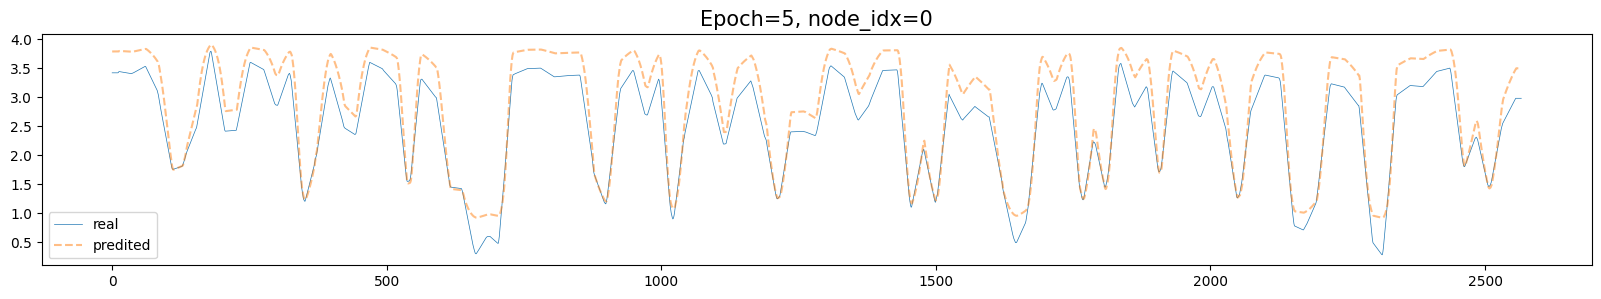

In [12]:
lrnr1.figs[-1]

In [14]:
lrnr2 = RGCN_Learner()
lrnr2.lags = 24
lrnr2.train_ratio = 0.8
lrnr2.load(yP)

lrnr2.nof_filters = 16
lrnr2.model = GC_LSTM(node_features=lrnr2.lags, filters=lrnr2.nof_filters).to(device)
lrnr2.optimizer = torch.optim.Adam(lrnr2.model.parameters(), lr=50/1000)

lrnr2.get_batches(128)
for e in range(5):
    lrnr2.learn()

epoch=1  loss=0.05164895358029753717718124  
epoch=2  loss=0.01803392556030303256122208  
epoch=3  loss=0.01447205175645649422351551  
epoch=4  loss=0.01320745862904004802891636  
epoch=5  loss=0.01272823920589871712669277  

In [15]:
yPhat = np.concatenate([np.array([list(lrnr2.yhat[0])]*lrnr2.lags),lrnr2.yhat],axis=0)
yPhat[yPhat<0] = 0

In [16]:
yP_mse = np.mean((yP - yPhat)**2)
yP_mse

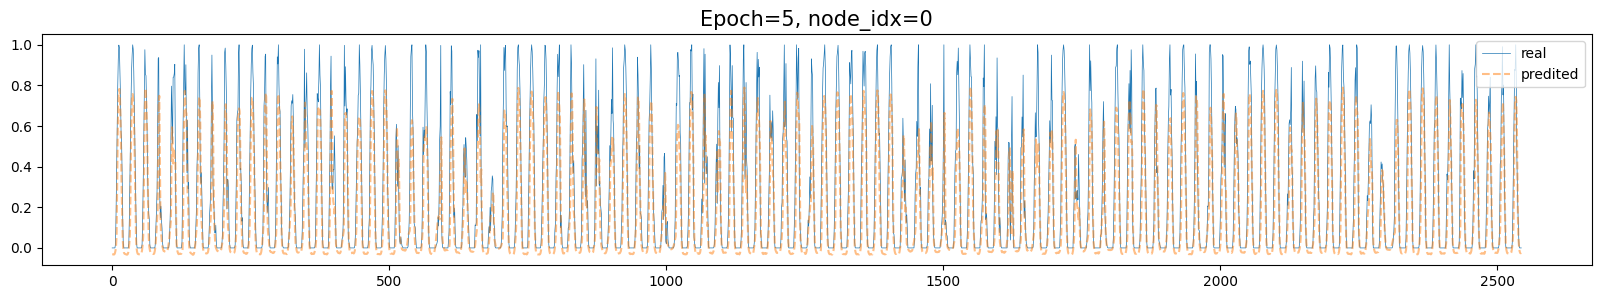

In [17]:
lrnr2.figs[-1]

In [18]:
classic = ((y - yhat)[LEN_TR:,:]**2).mean()
proposed = ((y - yUhat*yPhat)[LEN_TR:,:]**2).mean()
print('classic(mse)', round(classic,4))
print('proposed(mse)', round(proposed,4))

classic(mse) 0.1528
proposed(mse) 0.1335

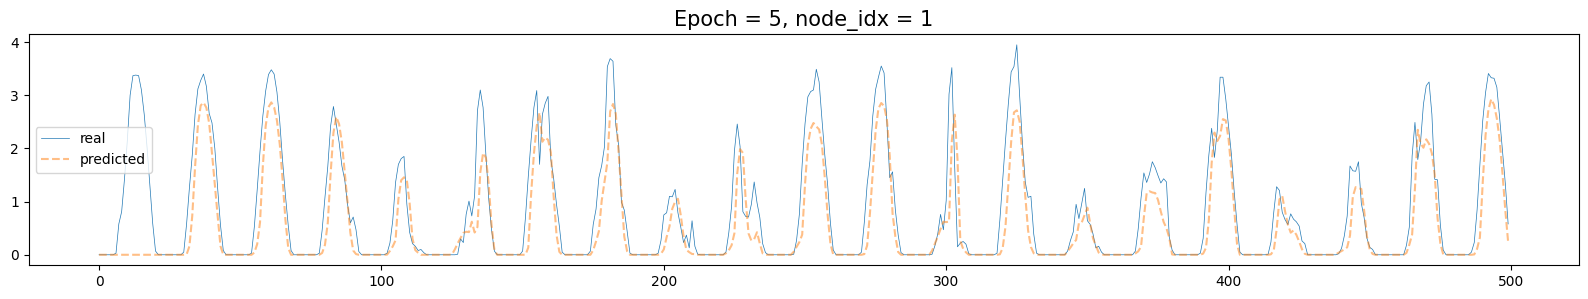

In [19]:
rslt_plot(lrnr2, y, yUhat*yPhat, 500, 1)

------------------------------------------------------------------------

In [20]:
%run test_model/glstm

In [38]:
s1 = Simulator()

In [ ]:
s1.simulate(
    n_iteration = 20,
    lags = [24],
    filters = [4, 8, 12, 16, 32],
    epoch = [5],
    Model = GC_LSTM,
    lr = 50/1000
)

batch=10     t=128   loss=0.5174433588981628    

In [40]:
import os
fnames = ['./test/'+l for l in os.listdir('./test') if l[0] != '.']
fnames 

In [41]:
import os

def NumIter(model_name, fnames):
    count = 0  # 'gconvlstm'이 포함된 파일 개수를 저장할 변수
    # 디렉토리 내의 모든 파일 검사
    for file_path in fnames:
        file_name = os.path.basename(file_path)
        if model_name in file_name:
            count += 1

    print(f"{model_name}이 포함된 파일 개수: {count}")

In [45]:
NumIter('dcrnn', fnames)
NumIter('gconvgru', fnames)
NumIter('gconvlstm', fnames)
NumIter('gclstm', fnames)

dcrnn이 포함된 파일 개수: 50
gconvgru이 포함된 파일 개수: 43
gconvlstm이 포함된 파일 개수: 50
gclstm이 포함된 파일 개수: 30

In [35]:
df = pd.concat([pd.read_csv(fname) for fname in fnames]).reset_index(drop=True)

In [43]:
def summary_table(df):
    model_name = input("모델명을 입력하세요: ")
    df = df[df['model']== model_name]
    df_summary = df.groupby(by=['model','method','lags','nof_filters']).agg({'mse':[np.mean, np.std]}).reset_index()
    df_classic = df_summary[df_summary['method']=='classic']
    df_proposed = df_summary[df_summary['method']=='proposed'].reset_index()[['method','mse']]
    df_compare = pd.concat([df_classic, df_proposed], axis=1)
    return df_compare

In [44]:
summary_table(df)

In [47]:
summary_table(df)

In [82]:
summary_table(df)

In [83]:
summary_table(df)